C:\Users\ment_lc\AppData\Local\Temp\ipykernel_13072\3821681548.py:650: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt = ["%.16f" % i for i in data]


  weights saved to weights_cn.pt,weights_vn.pt, and weights_llr.pt.

--- Training Metadata ---
Code: n=32, k=2, PCM rows=15,15
device: cpu
training ep0 = 0.1
Decoder: Neural BP Decoder
decoding iterations = 25
number of batches = 100
error patterns per batch = 200
learning rate = 1

training on random errors, epsilon from 0.015 to 0.15000000000000002 


loss 36.90, loss min 21.94, lr 0.92: 100%|██████████| 100/100 [2:29:44<00:00, 97.87s/it]  

  weights saved to weights_cn.pt,weights_vn.pt, and weights_llr.pt.



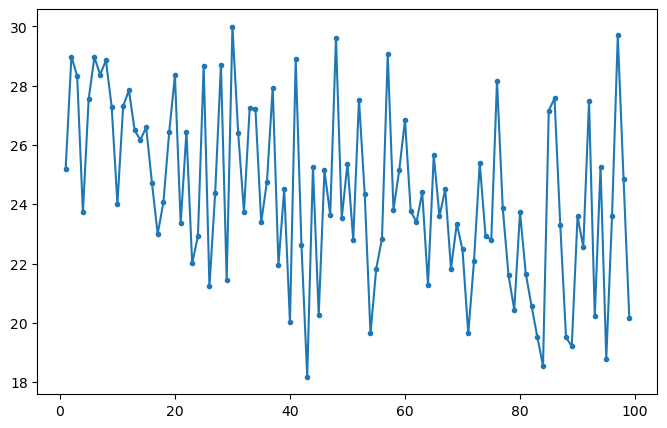

loss 36.90, loss min 21.94, lr 0.92: 100%|██████████| 100/100 [2:29:44<00:00, 89.85s/it]

  weights saved to weights_cn.pt,weights_vn.pt, and weights_llr.pt.

Training completed.



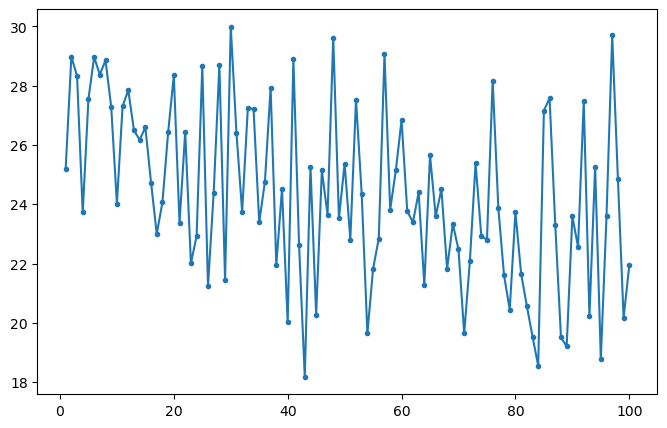

In [2]:
# Import external libraries
import torch

from tqdm import tqdm
import random
import matplotlib.pylab as plt
import numpy as np
# helper functions
import sys
import torch.nn as nn
import numpy as np
import os
import torch
import subprocess

# definition of NN
class NBP_oc(nn.Module):
    #initialitation of neural networks layers
    def __init__(self, n: int, k: int, m: int, m1: int, m2: int, codeType: str, n_iterations: int,
                 folder_weights: str = None,
                 batch_size: int = 1):
        super().__init__()

    #INITIALITATION OF PARAMETERS IN NN PART 1
        self.name = "Neural BP Decoder"
        self.batch_size = batch_size
        self.codeType = codeType
        self.n = n
        self.k = k

        # m_oc is the number rows of the overcomplete check matrix
        self.m_oc = m

        #what are these
        self.m1 = m1
        self.m2 = m2

        # m is the number of rows of the full rank check matrix
        self.m = n - k

        # If True, then all outgoing edges on the same CN has the same weight, configurable
        # sarebbero tutti i pesi w_c,i,j che escono da un singolo check node
        self.one_weight_per_cn = False
        self.rate = self.k / self.n
        self.n_iterations = n_iterations
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        #matrix full of 0 of css code with size number of data x qubit, sarebbero gli e'?
        self.xhat = torch.zeros((batch_size, self.n))
        self.zhat = torch.zeros((batch_size, self.n))
        self.load_matrices()


        #weight of the neural network right
        if not folder_weights:
            # initilize weights with 1 if none given
            self.ini_weight_as_one(n_iterations)
        else:
            # load pretrained weights stored in directory "folder":
            self.load_weights(folder_weights, self.device)


    #sarebbe il logaritmo della sommatoria  a denominatore giusto
    def fx(self, a: torch.tensor, b: torch.tensor) -> torch.Tensor:
        # ln(exp(x)+exp(y)) = max(x,y)+ln(1+exp(-|x-y|)
        return torch.max(a, b) + self.log1pexp(-1 * torch.abs(a - b))
    
    #sarebbe il numeratore giusto
    def log1pexp(self, x):
        # more stable version of log(1 + exp(x))
        m = nn.Softplus(beta=1, threshold=50)
        return m(x)
    
    #s=  H e^T, vera syndrome 
    def calculate_self_syn(self):
        #syndrome for x
        self.synx = torch.matmul(self.Hz, torch.transpose(self.errorx, 0, 1))
        #syndrome for z
        self.synz = torch.matmul(self.Hx, torch.transpose(self.errorz, 0, 1))

        #why do we swap indeces
        self.synx = torch.remainder(torch.transpose(self.synx, 2, 0), 2)
        self.synz = torch.remainder(torch.transpose(self.synz, 2, 0), 2)
        return torch.cat((self.synz, self.synx), dim=1)
    
    #gamma is the vector with three errors probabilities
    def loss(self, Gamma) -> torch.Tensor:
        """loss functions proposed in [1] eq. 11"""

        # first row, anti-commute with X, second row, anti-commute with Z, [1] eq. 10
        
        # minus 1 in gamma for negativity output (for the errors)
        prob = torch.sigmoid(-1.0 * Gamma).float()
      
       #prob ha due componenti orizzontali perche lo calcoli usando gamma all che ha una parte relativa all Hx e una Hz
        
        prob_aX = prob[:, 0, :]
        prob_aZ = prob[:, 1, :]


     # remove inf and not number in the probabilities
        assert not torch.isinf(prob_aX).any()
        assert not torch.isinf(prob_aZ).any()
        assert not torch.isnan(prob_aX).any()
        assert not torch.isnan(prob_aZ).any()

        # Depend on if the error commute with the entries in S_dual, which is denoted as G here
        # CSS constructions gives the simplification that Gx contains only X entries, and Gz contains on Z
        correctionx = torch.zeros_like(self.errorx)
        correctionz = torch.zeros_like(self.errorz)
       
       #ti fa una maschera, dove all'indice in cui qx uguale a 1 ti da il valore della probabilita sempre corrispondente a quell indice
        #ok quindi io avro 4 tensori q (uno per errore), che tuttavia non possono avere elementi uguali qx=[1,1,0,0]  qy=[0,0,1,0]  qz=[0,0,0,1]  qi=[0,0,0,0] altrimenti le probabilita si scambiano
       # correctionz sarebbero gli ei^?
       # mentre sti q?
        
        #cioe tu hai che se il prodotto scalare tra ei ed Sji=0 effettivamente non hai errore? (forse ci sta che consideri x in correzz perche non te lo becca?)
        #IMPORTANTE DISCUTERE PERCHE SE IL PRODOTTO SCALARE E 0 HAI STA ROBA (in particolare capire il senso perche mi aspetterei che errore su x non commuti con Hz e quindi non dovrebbe essere il contrario per probabilits)
        correctionz[self.qx == 1] = prob_aX[self.qx == 1]
        correctionz[self.qz == 1] = 1 - prob_aX[self.qz == 1]
        correctionz[self.qy == 1] = 1 - prob_aX[self.qy == 1]
        correctionz[self.qi == 1] = prob_aX[self.qi == 1]

        correctionx[self.qz == 1] = prob_aZ[self.qz == 1]
        correctionx[self.qx == 1] = 1 - prob_aZ[self.qx == 1]
        correctionx[self.qy == 1] = 1 - prob_aZ[self.qy == 1]
        correctionx[self.qi == 1] = prob_aZ[self.qi == 1]

        # first summ up the probability of anti-commute for all elements in each row of G , crei la sommatoria dentro f nella loss, CI sta sia la sindrome e il prodotto scalare tra la matrice di parita e l errore
        synx = torch.matmul(self.Gz, torch.transpose(correctionx.float(), 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz.float(), 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        syn_real = torch.cat((synz, synx), dim=1)


        loss = torch.zeros(1, self.batch_size)
        for b in range(self.batch_size):
            # the take the sin function, then summed up for all rows of G, calcoli la sommatoria e ottieni la loss per ciascun elemento della mini batch
            loss[0, b] = torch.sum(torch.abs(torch.sin(np.pi / 2 * syn_real[b, :, :])))

        assert not torch.isnan(loss).any()
        assert not torch.isinf(loss).any()

        return loss

    def loss_new(self, Gamma) -> torch.Tensor:
        """loss functions proposed in [1] eq. 11"""

        # first row, anti-commute with X, second row, anti-commute with Z, [1] eq. 10
        prob_aX = Gamma[:, 0, :]
        prob_aZ = Gamma[:, 1, :]

        assert not torch.isinf(prob_aX).any()
        assert not torch.isinf(prob_aZ).any()
        assert not torch.isnan(prob_aX).any()
        assert not torch.isnan(prob_aZ).any()

        # Depend on if the error commute with the entries in S_dual, which is denoted as G here
        # CSS constructions gives the simplification that Gx contains only X entries, and Gz contains on Z
        correctionx = torch.zeros_like(self.errorx)
        correctionz = torch.zeros_like(self.errorz)

        correctionz[self.qx == 1] = prob_aX[self.qx == 1]
        correctionz[self.qz == 1] = -1* prob_aX[self.qz == 1]
        correctionz[self.qy == 1] = -1* prob_aX[self.qy == 1]
        correctionz[self.qi == 1] = prob_aX[self.qi == 1]

        correctionx[self.qz == 1] = prob_aZ[self.qz == 1]
        correctionx[self.qx == 1] = -1* prob_aZ[self.qx == 1]
        correctionx[self.qy == 1] = -1* prob_aZ[self.qy == 1]
        correctionx[self.qi == 1] = prob_aZ[self.qi == 1]

        correctionx = torch.unsqueeze(correctionx, dim=1)
        x_msg = correctionx.repeat(1,(self.G_rows)//2,1) * self.Gz

        correctionz = torch.unsqueeze(correctionz, dim=1)
        z_msg = correctionz.repeat(1, (self.G_rows) // 2, 1) * self.Gx

        msg = torch.cat((z_msg,x_msg), dim=1)
        msg = torch.clip(msg, -5.0, 5.0)

        msg_sign = torch.sign(msg)
        msg_sign[msg == 0] = 1
        msg_sign = torch.prod(msg_sign, dim=2, keepdim=True)

        msg_abs = torch.abs(msg)
        msg_abs[msg_abs<1e-6] = 1e-6

        phi_msg = -1.0 * torch.log(torch.tanh(msg_abs / 2.0))
        phi_msg[msg==0] = 0
        phi_msg_sum = torch.sum(phi_msg, dim=2, keepdim=True)
        phi_phi_msg = -1.0 * torch.log(torch.tanh(phi_msg_sum / 2.0))
        syn_real = msg_sign * phi_phi_msg



        # # first summ up the probability of anti-commute for all elements in each row of G
        # synx = torch.matmul(self.Gz, torch.transpose(correctionx.float(), 0, 1))
        # synz = torch.matmul(self.Gx, torch.transpose(correctionz.float(), 0, 1))
        # synx = torch.transpose(synx, 2, 0)
        # synz = torch.transpose(synz, 2, 0)
        # syn_real = torch.cat((synz, synx), dim=1)


        loss = torch.zeros(1, self.batch_size)
        for b in range(self.batch_size):
            loss[0, b] = -1*torch.sum(syn_real[b,:,:])

        assert not torch.isnan(loss).any()
        assert not torch.isinf(loss).any()

        return loss
    

    # quindi qui calcoli i valori di lambda piccolo e dei Gamma
    def variable_node_update(self, incoming_messages, llr, weights_vn, weights_llr):
        # As we deal with CSS codes, all non-zero entries on the upper part anti-commute with Z and Y and commute with X
        # all non-zero entries on the upper part anti-commute with X and Y and commute with Z
        # Then the calculation can be done in matrices => speed up training (probably)
        
        #llr=log likelihood ratio


        # sarebbero i delta? guarda quaderno
        incoming_messages_upper = incoming_messages[:, 0:self.m1, :]
        incoming_messages_lower = incoming_messages[:, self.m1:self.m_oc, :]
        incoming_messages_upper.to(self.device)
        incoming_messages_lower.to(self.device)


        #formula  pag 7 (i pesi per delta sono dentro incoming credo), effetivamente ci sta che siano 3 dato che gamma e un vettore a 3 componenti
        Gammaz = llr * weights_llr + torch.sum(incoming_messages_upper, dim=1, keepdim=True)
        Gammax = llr * weights_llr + torch.sum(incoming_messages_lower, dim=1, keepdim=True)
        Gammay = llr * weights_llr + torch.sum(incoming_messages, dim=1, keepdim=True)

        Gammaz.double().to(self.device)
        Gammax.double().to(self.device)
        Gammay.double().to(self.device)

        # can be re-used for hard-decision in decoding, but not used in training as we don't check for decoding success
        # we are only interested in the loss during training , gamma e una matrice di scalari 
        #sarebbe il vettore gamma senza formula 5 applicata (CHIEDERE)
        # cioe ti restituisce una matrice con colonne gammay,gammax,gammaz e righe i tuoi VN
        Gamma = torch.cat((Gammay, Gammax, Gammaz), dim=1).to(self.device)

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()
        
        # formula 5 con considerazioni formula sopra, ci sta che upper sia x dato che la prima parte della matrice e x (mentre sopra fai il contrario perche gamma ti contiene errore?)
        # outgoing messagges sono i lambda piccoli
        outgoing_messages_upper = self.log1pexp(-1.0 * Gammax) - self.fx(-1.0 * Gammaz, -1.0 * Gammay)
        outgoing_messages_lower = self.log1pexp(-1.0 * Gammaz) - self.fx(-1.0 * Gammax, -1.0 * Gammay)

        #sarebbe la formula 5 per tutto (chiedere di preciso cosa e) perche lui sfrutta sti outgoing pero per quello dopo moltiplica per Hz e Hx4||||||||||||||||||||||
        Gamma_all = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1).to(self.device)
        
       # we multiply by Hx and Hz for decode constraints and stability, cioe la differenza tra gamma all e outgoing e che outgoing viene moltiplicato per Hz e Hx in modo da raggiungere la dimensionalita giusta nel decoder?
        outgoing_messages_upper = outgoing_messages_upper * self.Hx
        outgoing_messages_lower = outgoing_messages_lower * self.Hz
        outgoing_messages = torch.cat((outgoing_messages_upper, outgoing_messages_lower), dim=1)

       # subtraction enables refinement of codeword bit estimates, mainteining consistency between messages and help to converge
        outgoing_messages = outgoing_messages - incoming_messages
        outgoing_messages = outgoing_messages * self.H

        assert not torch.isinf(Gammaz).any()
        assert not torch.isinf(Gammax).any()
        assert not torch.isinf(Gammay).any()

        # to avoid numerical issues
        outgoing_messages = torch.clip(outgoing_messages, -30.0, 30.0)

        return outgoing_messages.float() * weights_vn, Gamma, Gamma_all
    


    def check_node_update(self, incoming_messages: torch.Tensor, weights_cn: torch.Tensor) -> torch.Tensor:
        
        #how much in dept have i to go for this?
        #sarebbe la -1^zj ?
        multipicator = torch.pow(-1, self.syn)
        multipicator = multipicator * self.H

        # use the simplification with the phi function to turn multipilication to addtion
        # a bit more troublesome than the usual SPA, because want to do it in matrix

        #crei un tensore con i segni e fai la maschera dove 0 metti 1
        incoming_messages_sign = torch.sign(incoming_messages)
        incoming_messages_sign[incoming_messages == 0] = 1


        first_part = torch.prod(incoming_messages_sign, dim=2, keepdim=True)
        first_part = first_part * self.H
        first_part = first_part / incoming_messages_sign
        first_part = self.H * first_part
        assert not torch.isinf(first_part).any()
        assert not torch.isnan(first_part).any()

        incoming_messages_abs = torch.abs(incoming_messages).double()
        helper = torch.ones_like(incoming_messages_abs)
        helper[incoming_messages_abs == 0] = 0
        incoming_messages_abs[incoming_messages == 0] = 1.0

        phi_incoming_messages = -1.0 * torch.log(torch.tanh(incoming_messages_abs / 2.0))
        phi_incoming_messages = phi_incoming_messages * helper
        phi_incoming_messages = phi_incoming_messages * self.H

        temp = torch.sum(phi_incoming_messages, dim=2, keepdim=True)
        Aij = temp * self.H

        sum_msg = Aij - phi_incoming_messages
        helper = torch.ones_like(sum_msg)
        helper[sum_msg == 0] = 0
        sum_msg[sum_msg == 0] = 1.0

        second_part = -1 * torch.log(torch.tanh(sum_msg / 2.0))
        second_part = second_part * helper
        second_part = second_part * self.H
        assert not torch.isinf(second_part).any()
        assert not torch.isnan(second_part).any()

        outgoing_messages = first_part * second_part
        outgoing_messages = outgoing_messages * multipicator


      # basically formula 6 right involved in 10?
        outgoing_messages = (outgoing_messages * weights_cn).float()
        return outgoing_messages

    def forward(self, errorx: torch.Tensor, errorz: torch.Tensor, ep: float, batch_size=1) -> torch.Tensor:
        """main decoding procedure"""

        #crei il tuo vettore in cui metterai i valori della loss, avrai un array con le righe corrispondenti agli errori creati e le colonne corrispondenti alle iterazioni nel decoder
        loss_array = torch.zeros(self.batch_size, self.n_iterations).float().to(self.device)

        assert batch_size == self.batch_size
        

        #sarebbero gli e_i veri?
        self.errorx = errorx.to(self.device)
        self.errorz = errorz.to(self.device)
        

        #chiedere che cosa sono questi q for optimization
        self.qx = torch.zeros_like(self.errorx)
        self.qz = torch.zeros_like(self.errorx)
        self.qy = torch.zeros_like(self.errorx)
        self.qi = torch.ones_like(self.errorx)

        self.qx[self.errorx == 1] = 1
        self.qx[self.errorz == 1] = 0

        self.qz[self.errorz == 1] = 1
        self.qz[self.errorx == 1] = 0

        self.qy[self.errorz == 1] = 1
        self.qy[self.errorx != self.errorz] = 0

        self.qi[self.errorx == 1] = 0
        self.qi[self.errorz == 1] = 0
        

        #calcoli la sindrome z sfruttando errorx and errorz (li conosciamo questi?)
        self.syn = self.calculate_self_syn()

        # initial LLR to, first equation in [1,Sec.II-C]
        llr = np.log(3 * (1 - ep) / ep)
        

        #inizializzi a 0 i delta grandi
        messages_cn_to_vn = torch.zeros((batch_size, self.m_oc, self.n)).to(self.device)
        self.batch_size = batch_size

        # initlize VN message, prendi i delta a 0 (prima iterazione), e quindi inizializzerai con solo i valori di llr con i pesi associati, senza tutta la parte di sommatoria, sarebbe il tuo vettore gamma
        messages_vn_to_cn, _, _ = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[0],
                                                            self.weights_llr[0])

        # iteratively decode, decode will continue till the max. iteration, even if the syndrome already matched
        #ok in this case the weights are fixed? no update?
        #cioe ti fa il decoding per ogni elemento della batch? ci sta perche tu vuoi la syndrome e l errore per ogni errore che metti
        for i in range(self.n_iterations):
            assert not torch.isnan(self.weights_llr[i]).any()
            assert not torch.isnan(self.weights_cn[i]).any()
            assert not torch.isnan(messages_cn_to_vn).any()
            
            # ti ritorna i delta con il rispettivo peso
            # check node update:
            messages_cn_to_vn = self.check_node_update(messages_vn_to_cn, self.weights_cn[i])

            assert not torch.isnan(messages_cn_to_vn).any()
            assert not torch.isinf(messages_cn_to_vn).any()
            
            #ti resituisce i gamma eq 7 e sfrutta i lambda piccolo per convertirlo in uno scalare, infatti ti ritorna 3 cose tra cui i gamma quindi a fine iterazione li avrai per l hard decision
            # variable node update:
            messages_vn_to_cn, Tau, Tau_all = self.variable_node_update(messages_cn_to_vn, llr, self.weights_vn[i + 1],
                                                                        self.weights_llr[i + 1])

            assert not torch.isnan(messages_vn_to_cn).any()
            assert not torch.isinf(messages_vn_to_cn).any()
            assert not torch.isnan(Tau).any()
            assert not torch.isinf(Tau).any()

            loss_array[:, i] = self.loss(Tau_all)


        # ti restituisce l indice minimo della loss finite l iterazioni nel decoding (cioe ti dice a quale iterazione l indice e minimo?)
            # e ti da una loss per ogni batch size?
        _, minIdx = torch.min(loss_array, dim=1, keepdim=False)

        loss = torch.zeros(self.batch_size, ).float().to(self.device)
        loss_min = torch.zeros(self.batch_size, ).float().to(self.device)
        # take average of the loss for the first iterations till the loss is minimized
        for b in range(batch_size):
            # for idx in range(minIdx[b] + 1):
            #     loss[b] += loss_array[b, idx]
            # loss[b] /= (minIdx[b] + 1)

            #ok vai a cercare nella loss array il valore minimo della loss per ciascuna batch, quindi all elemento b=1 prenderai il valore alla riga 1 di loss array e alla colonna con il minimo corrispondente
            loss_min[b] = loss_array[b, minIdx[b]]

            #sostanzialmente calcoli la loss per ogni batch size, quindi sommi tutti i valori di una riga e trovi la loss per primo elemento, ecc
            for idx in range(self.n_iterations):
                loss[b] += loss_array[b, idx]
            #normalizzi perche dividi per numero di iterazioni dato che vuoi la media
            loss[b] /= self.n_iterations

        # loss finale come somma di tutte le loss divisa la batch size
        loss = torch.sum(loss, dim=0) / self.batch_size
        loss_min = torch.sum(loss_min, dim=0) / self.batch_size

        assert not torch.isnan(loss)
        assert not torch.isinf(loss)
        return loss, loss_min



    # gli dai in input i gammai che hai trovato per ciascuna batch e ti ritorna la sindrome finale e ti dice se ha mecciato o no, quindi se hai avuto o meno successo
    def check_syndrome(self, Tau):
        """performs hard decision to give the estimated error and check for decoding success.
        However, not used in the current script, as we are only performing trainig"""

        #tmp vettore con righe= numero di errori e una colonna e Tau sarebbero i tuoi gamma 
        tmp = torch.zeros(self.batch_size, 1, self.n).to(self.device)
        Tau = torch.cat((tmp, Tau), dim=1)


       # argmin gamma 
        minVal, minIdx = torch.min(Tau, dim=1, keepdim=False)

        self.xhat = torch.zeros((self.batch_size, self.n)).to(self.device)
        self.zhat = torch.zeros((self.batch_size, self.n)).to(self.device)
        

        #why do we consider index 2 3 ? maybe because they correspond to z x error while 1 to y?
        self.xhat[minIdx == 1] = 1
        self.xhat[minIdx == 2] = 1

        self.zhat[minIdx == 1] = 1
        self.zhat[minIdx == 3] = 1
        m = torch.nn.ReLU()
        
        #fa il prodotto tra l errore e l Hz

        #X-type errore, why do we multiply Hx whit xhat? maybe because xhat e la matrice con tutti gli errori? ha senso perche tu avrai una matrice totale per tutti gli errori che confronti con Hz
        synx = torch.matmul(self.Hz, torch.transpose(self.xhat, 0, 1))

        #Z-type error
        synz = torch.matmul(self.Hx, torch.transpose(self.zhat, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)
        synhat = torch.remainder(torch.cat((synz, synx), dim=1), 2)
        

        # self.syn sarebbe la syndrome vera calcolata a priori giusto? synhat quella ottenuta invece con BP?cioe tra e ed e"?
        syn_match = torch.all(torch.all(torch.eq(self.syn, synhat), dim=1), dim=1)
        

        # formula 3 prodotto scalare (sarebbe la sindrome con la correzione?) Non capisco la differenza tra le tre sindrome syn,synhat syn-real?
        correctionx = torch.remainder(self.xhat + self.errorx, 2)
        correctionz = torch.remainder(self.zhat + self.errorz, 2)
        synx = torch.matmul(self.Gz, torch.transpose(correctionx, 0, 1))
        synz = torch.matmul(self.Gx, torch.transpose(correctionz, 0, 1))
        synx = torch.transpose(synx, 2, 0)
        synz = torch.transpose(synz, 2, 0)

        # ti rit
        self.syn_real = torch.cat((synz, synx), dim=1)

        syn_real = torch.remainder(self.syn_real, 2)
        tmmp = torch.sum(syn_real, dim=1, keepdim=False)

        #check formula 3 dia 0 come ci aspettavamo o no
        success = torch.all(torch.eq(torch.sum(syn_real, dim=1, keepdim=False), 0), dim=1)
        return syn_match, success

    def unsqueeze_batches(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Checks if tensor is 2D or 3D. If tensor is 2D, insert extra dimension (first dimension)
        This method can be used to allow decoding of
            batches of codewords (batch size, m, n)
            as well as single codewords (m, n)
        """
        if tensor.dim() == 3:
            return tensor
        elif tensor.dim() == 2:
            return torch.unsqueeze(tensor, dim=0)

    # continue with the NBP_oc class, some tool functions
    def load_matrices(self):
        """reads in the check matrix for decoding as well as the dual matrix for checking decoding success"""
        file_nameGx = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gx.alist"
        file_nameGz = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_Gz.alist"
        Gx = readAlist(file_nameGx)
        Gz = readAlist(file_nameGz)
        self.G_rows = 2*Gx.shape[0]

        file_nameH = "./PCMs/" + self.codeType + "_" + str(self.n) + "_" + str(
            self.k) + "/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_H_" + str(self.m_oc) + ".alist"
       

        #la matrice ha come righe gli stabilizer indicando su quale qubit agisce
        H = readAlist(file_nameH)
        self.H = H
        Hx = H[0:self.m1, :]
        Hz = H[self.m1:self.m_oc, :]
        Gx = torch.from_numpy(Gx).float()
        Gz = torch.from_numpy(Gz).float()
        G = torch.cat((Gx,Gz),dim=0)
        Hx = torch.from_numpy(Hx).float()
        Hz = torch.from_numpy(Hz).float()

        # first dim for batches.
        self.Hx = self.unsqueeze_batches(Hx).float().to(self.device)
        self.Hz = self.unsqueeze_batches(Hz).float().to(self.device)
        self.Gx = self.unsqueeze_batches(Gx).float().to(self.device)
        self.Gz = self.unsqueeze_batches(Gz).float().to(self.device)
        self.G = self.unsqueeze_batches(G).float().to(self.device)

        self.H = torch.cat((self.Hx, self.Hz), dim=1).float().to(self.device)
        self.H_reverse = 1 - self.H
    def load_weights(self, directory: str, device: str):
        """
        Load pretrained weights.Parameters directory : str directory where pretrained weights are stored as "weights_vn.pt", "weights_cn.pt" or "weights_llr.pt".
        device : str cpu' or 'cuda'
        """
        print('continue training with previous weights')

        if device == 'cpu':
            weights_vn = torch.load(directory + 'weights_vn.pt', map_location=torch.device('cpu'))
            weights_cn = torch.load(directory + 'weights_cn.pt', map_location=torch.device('cpu'))
            weights_llr = torch.load(directory + 'weights_llr.pt', map_location=torch.device('cpu'))

        else:
            weights_cn = torch.load(directory + 'weights_cn.pt')
            weights_vn = torch.load(directory + 'weights_vn.pt')
            weights_llr = torch.load(directory + 'weights_llr.pt')

        self.weights_llr = weights_llr
        self.weights_cn = weights_cn
        self.weights_vn = weights_vn


    def ini_weight_as_one(self, n_iterations: int):
        """this function can be configured to determine which parameters are trainablecan be configured to determine which parameters are trainable"""
        """this function can be configured to determine which parameters are trainablecan be configured to determine which parameters are trainable"""
        self.weights_llr = []
        self.weights_cn = []
        self.weights_vn = []
        if self.m_oc < self.n:
            self.weights_llr = []
            self.weights_cn = []
            self.weights_vn = []
            #fa per n iterazioni perche poi per ogni iterazione va ad aggiornarlo
            for i in range(n_iterations):
                if self.one_weight_per_cn:
                    self.weights_cn.append(torch.ones((1, self.m_oc, 1), requires_grad=True, device=self.device))
                else:
                    self.weights_cn.append(torch.ones((1, self.m_oc, self.n), requires_grad=True, device=self.device))
                self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=True, device=self.device))
                self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=True, device=self.device))
            self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=True, device=self.device))
            self.weights_llr.append(torch.ones((1, 1, self.n), requires_grad=True, device=self.device))
        else:
            self.ini_weights = np.array([1.0,0.1])
            temp = self.ini_weights[0] * np.ones((1, 1, self.n))
            l1 = (self.n) // 2
            l2 = self.m_oc // 2 - l1

            temp_vn = []
            if self.one_weight_per_cn:
                temp_vn = np.concatenate((np.ones((1, l1, 1)), self.ini_weights[1] * np.ones((1, l2, 1))),
                                         axis=1)
            else:
                temp_vn = np.concatenate(
                    (np.ones((1, l1, self.n)),
                     self.ini_weights[1] * np.ones((1, l2, self.n))), axis=1)
            temp_vn = np.concatenate((temp_vn, temp_vn), axis=1)

            for i in range(n_iterations):
                self.weights_llr.append(torch.from_numpy(temp).float().to(self.device))
                self.weights_llr[i].requires_grad = True

                self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=True, device=self.device))
                self.weights_cn.append(torch.from_numpy(temp_vn).float().to(self.device))
                self.weights_cn[i].requires_grad = True



            self.weights_llr.append(torch.from_numpy(temp).float().to(self.device))
            self.weights_llr[i].requires_grad = True
            self.weights_llr[n_iterations].requires_grad = True
            self.weights_vn.append(torch.ones(1, self.m_oc, self.n, requires_grad=True, device=self.device))
        self.save_weights()

    def save_weights(self):
        """weights are saved twice, once as .pt for python, once as .txt for c++"""
        path = "./training_results/" + self.codeType + "_" + str(self.n) + "_" + str(self.k) + "_" + str(self.m_oc) + "/"
        os.makedirs(path, exist_ok=True)
        # some parameters may not be trained, but we save them anyway
        file_vn = "weights_vn.pt"
        file_cn = "weights_cn.pt"
        file_llr = "weights_llr.pt"

        torch.save(self.weights_vn, os.path.join(path, file_vn))
        torch.save(self.weights_cn, os.path.join(path, file_cn))
        torch.save(self.weights_llr, os.path.join(path, file_llr))
        print(f'  weights saved to {file_cn},{file_vn}, and {file_llr}.\n')

        # the following codes save the weights into txt files, which is used for C++ code for evaluating the trained
        # decoder. So the C++ codes don't need to mess around with python packages
        # not very elegant but will do for now
        if sys.version_info[0] == 2:
            import cStringIO
            StringIO = cStringIO.StringIO
        else:
            import io

        StringIO = io.StringIO

        # write llr weights, easy
        f = open(path + "weight_llr.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_llr)))
            for i in self.weights_llr:
                data = i.detach().cpu().numpy().reshape(self.n, 1)
                opt = ["%.16f" % i for i in data]
                output.write(' '.join(opt))
                output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write CN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_cn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_cn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxRowWeight = max(rowWeights)

            if self.one_weight_per_cn:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, 1)
                    for rowId in range(nRows):
                        opt = ["%.16f" % i for i in matrix[rowId]]
                        for i in range(rowWeights[rowId].astype('int') - 1):
                            output.write(opt[0])
                            output.write(' ')
                        output.write(opt[0])
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - rowWeights[rowId] - 1).astype('int'))
                        output.write('\n')
            else:
                # column-wise nonzeros block
                for i in self.weights_cn:
                    matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                    matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                    for rowId in range(nRows):
                        nonzeroIndices = np.flatnonzero(matrix[rowId, :])  # AList uses 1-based indexing
                        output.write(' '.join(map(str, matrix[rowId, nonzeroIndices])))
                        # fill with zeros so that every line has maxDegree number of entries
                        output.write(' 0' * (maxRowWeight - len(nonzeroIndices)))
                        output.write('\n')
            f.write(output.getvalue())
        f.close()

        # write VN weights
        H_tmp = self.H.detach().cpu().numpy().reshape(self.m_oc, self.n)
        H_tmp = np.array(H_tmp, dtype='int')
        f = open(path + "weight_vn.txt", "w")
        with StringIO() as output:
            output.write('{}\n'.format(len(self.weights_vn)))
            nRows, nCols = H_tmp.shape
            # first line: matrix dimensions
            output.write('{} {}\n'.format(nCols, nRows))

            # next three lines: (max) column and row degrees
            colWeights = H_tmp.sum(axis=0)
            rowWeights = H_tmp.sum(axis=1)

            maxColWeight = max(colWeights)

            # column-wise nonzeros block
            for i in self.weights_vn:
                matrix = i.detach().cpu().numpy().reshape(self.m_oc, self.n)
                matrix *= self.H[0].detach().cpu().numpy().reshape(self.m_oc, self.n)
                for colId in range(nCols):
                    nonzeroIndices = np.flatnonzero(matrix[:, colId])  # AList uses 1-based indexing
                    output.write(' '.join(map(str, matrix[nonzeroIndices, colId])))
                    # fill with zeros so that every line has maxDegree number of entries
                    output.write(' 0' * (maxColWeight - len(nonzeroIndices)))
                    output.write('\n')
            f.write(output.getvalue())
        f.close()

#quindi alla fine della fiera le parity check matrix avranno solo 0 e 1 giusto? cioe tipo quella del toric verra convertita cosi dai numeri che abbiamo no?
def readAlist(directory):
    '''
    Reads in a parity check matrix (pcm) in A-list format from text file. returns the pcm in form of a numpy array with 0/1 bits as float64.
    '''

    alist_raw = []
    with open(directory, "r") as f:
        lines = f.readlines()
        for line in lines:
            # remove trailing newline \n and split at spaces:
            line = line.rstrip().split(" ")
            # map string to int:
            line = list(map(int, line))
            alist_raw.append(line)
    alist_numpy = alistToNumpy(alist_raw)
    alist_numpy = alist_numpy.astype(float)
    return alist_numpy


def alistToNumpy(lines):
    '''Converts a parity-check matrix in AList format to a 0/1 numpy array'''
    nCols, nRows = lines[0]
    if len(lines[2]) == nCols and len(lines[3]) == nRows:
        startIndex = 4
    else:
        startIndex = 2
    matrix = np.zeros((nRows, nCols), dtype=float)
    for col, nonzeros in enumerate(lines[startIndex:startIndex + nCols]):
        for rowIndex in nonzeros:
            if rowIndex != 0:
                matrix[rowIndex - 1, col] = 1
    return matrix



def optimization_step(decoder, ep0, optimizer: torch.optim.Optimizer, errorx, errorz, scheduler=None):
    # call the forward function

    #sarebbe la tua rete neurale
    loss, loss_min = decoder(errorx, errorz, ep0, batch_size=batch_size)

    # delete old gradients.
    optimizer.zero_grad()
    # calculate gradient
    loss_min.backward()
    clip_value = 0.001
    for p in range(n_iterations):
        decoder.weights_vn[p].grad.data.clamp_(-clip_value, clip_value)
        decoder.weights_cn[p].grad.data.clamp_(-clip_value, clip_value)
        decoder.weights_llr[p].grad.data.clamp_(-clip_value, clip_value)
    #

    # update weights
    optimizer.step()
    scheduler.step()

    # print(f'loss: {loss}')
    # print('cn gradient===========')
    # for i in range(decoder.n_iterations):
    #     weights_cn_grad = decoder.weights_cn[i].grad.detach().clone().cpu()
    #     print(
    #         f'it. {i}, ave. abs. {np.average(abs(weights_cn_grad))}, ave. {np.average(weights_cn_grad)}')
    # print('vn gradient===========')
    # for i in range(decoder.n_iterations):
    #     weights_cn_grad = decoder.weights_vn[i].grad.detach().clone().cpu()
    #     print(
    #         f'it. {i}, ave. abs. {np.average(abs(weights_cn_grad))}, ave. {np.average(weights_cn_grad)}')
    # print('llr gradient===========')
    # for i in range(decoder.n_iterations):
    #     weights_llr_grad = decoder.weights_llr[i].grad.detach().clone().cpu()
    #     print(f'it. {i}, ave. abs. {np.average(abs(weights_llr_grad))}, ave. {np.average(weights_llr_grad)}')


    return loss.detach(), loss_min.detach()


#generazione degli errori
def addDeploarizationErrorGiveEp(n: int, ep:float, batch_size:int = 1):
    errorx = torch.zeros((batch_size, n))
    errorz = torch.ones((batch_size, n))
    np.random.seed()
    for b in range(batch_size):
        a = torch.from_numpy(np.random.rand(n,))
        # iny = (a <= ep / 3).reshape(n,)
        errorx[b, (a <= 2.0 * ep / 3.0)] = 1
        errorz[b, (a < ep / 3.0)] = 0
        errorz[b, (a > ep)] = 0
    return errorx, errorz


def training_loop(decoder, optimizer, ep1, sep,num_points, ep0, num_batch, path, scheduler=None):
    print(f'training on random errors, epsilon from {ep1} to {ep1+sep*(num_points-1)} ')
    loss_length = num_batch
    loss = torch.zeros(loss_length)
    loss_min = torch.zeros(loss_length)

    idx = 0
    with tqdm(total=loss_length) as pbar:
        for i_batch in range(num_batch):
            errorx = torch.tensor([])
            errorz = torch.tensor([])
            for i in range(num_points):
                ex, ez = addDeploarizationErrorGiveEp(decoder.n, ep1+i*sep, decoder.batch_size//num_points)
                errorx = torch.cat((errorx, ex), dim=0)
                errorz = torch.cat((errorz, ez), dim=0)


            loss[idx], loss_min[idx] = optimization_step(decoder, ep0, optimizer, errorx, errorz,scheduler)
            pbar.update(1)
            pbar.set_description(f"loss {loss[idx]:.2f}, loss min {loss_min[idx]:.2f}, lr {scheduler.get_last_lr()[1]:.2f}")
            idx += 1


            if ((i_batch+1)%100==0):
                decoder.save_weights()
                plot_loss(loss_min[0:idx-1], path=None)

    decoder.save_weights()
    print('Training completed.\n')
    return loss_min

def plot_loss(loss, path, myrange=0):
    f = plt.figure(figsize=(8, 5))
    if myrange > 0:
        plt.plot(range(1, myrange + 1), loss[0:myrange], marker='.')
    else:
        plt.plot(range(1, loss.size(dim=0) + 1), loss, marker='.')
    plt.show()
    if path!=None:
        file_name = path + "/loss.pdf"
        f.savefig(file_name)
    plt.close()


def addErrorGivenWeight(n: int, w: int, batch_size: int = 1):
    errorx = torch.zeros((batch_size, n))
    errorz = torch.zeros((batch_size, n))
    li = list(range(0, n))
    for b in range(batch_size):
        pos = random.sample(li, w)
        al = torch.rand([w, ])
        for p, a in zip(pos, al):
            if a < 1 / 3:
                errorx[b, p] = 1
            elif a < 2 / 3:
                errorz[b, p] = 1
            else:
                errorx[b, p] = 1
                errorz[b, p] = 1
    return errorx, errorz



# give parameters for the code and decoder
torch.autograd.set_detect_anomaly(True)
L = 4
n = 2*L*L
k = 2
#m = 3*n  # number of checks, can also use 46 or 44
m= n-k
#m=46
m1 = m // 2
m2 = m // 2
n_iterations = 25
codeType = 'toric'

# give parameters for training
# learning rate
lr = 1
# training for fixed epsilon_0
ep0 = 0.1
ep1=0.015
num_points = 10
sep=0.015
if m==3*n:
    ep0 = 0.1
    ep1+=0.06
# train on errors of weight ranging from r1 to r2
r1 = 1
r2 = 5
# number of updates
n_batches = 100
# number of error patterns in each mini batch
batch_size = 20*num_points

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
# initialize the decoder, all weights are set to 1
decoder = NBP_oc(n, k, m, m1, m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
# f = plt.figure(figsize=(5, 8))
# plt.spy(decoder.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
# plt.title("check matrix of the [[" + str(n) + "," + str(k) + "]] code with " + str(m) + " checks")
# plt.show()
#
# # for comparision, also plot the original check matrix
# decoder_2 = NBP_oc(n, k, n - k, m1, m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
# f = plt.figure(figsize=(5, 3))
# plt.spy(decoder_2.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
# plt.title("check matrix of the [[" + str(n) + "," + str(k) + "]] code with " + str(n - k) + " checks")
# plt.show()


# use Adam
optimizer = torch.optim.SGD([
    {'params': decoder.weights_llr, 'lr': lr},
    {'params': decoder.weights_vn,'lr': lr},
    {'params': decoder.weights_cn,'lr': lr}
    ])
# optimizer = torch.optim.Adam(parameters, lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=1.0, end_factor=0.1, total_iters=1200)

print('--- Training Metadata ---')
print(f'Code: n={decoder.n}, k={decoder.k}, PCM rows={decoder.m1},{decoder.m2}')
print(f'device: {decoder.device}')
print(f'training ep0 = {ep0}')
print(f'Decoder: {decoder.name}')
print(f'decoding iterations = {decoder.n_iterations}')
print(f'number of batches = {n_batches}')
print(f'error patterns per batch = {batch_size}')
print(f'learning rate = {lr}\n')

#cpp_executable = './sim_FER'
#cpp_parameters = ['-d','128','2',str(m), '25', '1', '-i',str(ep0),'-r','0.15','0.015','0.015']
# pre-training stage, basically only the parameters for the first iteration is trained
loss = torch.Tensor()

loss_pre_train = training_loop(decoder, optimizer, ep1, sep,num_points, ep0, n_batches, path, scheduler=scheduler)
loss = torch.cat((loss, loss_pre_train), dim=0)
plot_loss(loss, path)
#subprocess.call([cpp_executable] + cpp_parameters)

In [3]:
import subprocess
subprocess.check_output(["start","./nbp4"],shell=True)

b''

(0.001, 1)

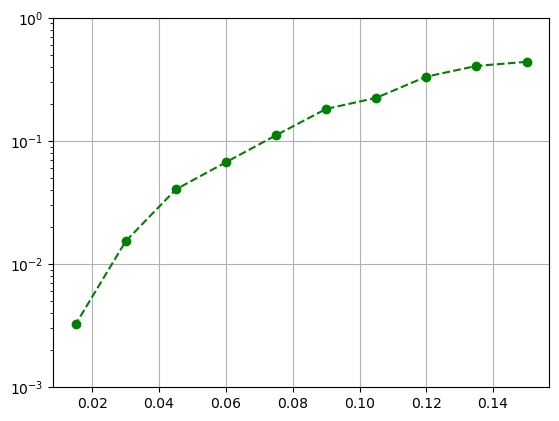

In [4]:
import matplotlib.pylab as plt
import numpy as np
a=np.array([0.15,0.135,0.12,0.105,0.09,0.075,0.06,0.045,0.03,0.015])
b=np.array([0.438137,0.40566, 0.33223,  0.22346,0.181654,0.111029, 0.0670528, 0.0403323 ,0.0153321,0.00324147])

plt.plot(a,b,color='green', marker='o', linestyle='dashed')
plt.yscale('log',base=10)
plt.grid()
# Set y-axis limits from 10^0 to 10^-3
plt.ylim(10**-3, 10**0)

d=6

In [5]:
L = 6
n = 2*L*L
k = 2
#m = 3*n  # number of checks, can also use 46 or 44
m= n-k
#m=46
m1 = m // 2
m2 = m // 2
n_iterations = 25
codeType = 'toric'

# give parameters for training
# learning rate
lr = 1
# training for fixed epsilon_0
ep0 = 0.1
ep1=0.015
num_points = 10
sep=0.015
if m==3*n:
    ep0 = 0.1
    ep1+=0.06
# train on errors of weight ranging from r1 to r2
r1 = 1
r2 = 5
# number of updates
n_batches = 100
# number of error patterns in each mini batch
batch_size = 20*num_points

# path where the training weights are stored, also supports training with previously stored weights
path = "./training_results/" + codeType + "_" + str(n) + "_" + str(k) + "_" + str(m) + "/"
# initialize the decoder, all weights are set to 1
decoder = NBP_oc(n, k, m, m1, m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
# f = plt.figure(figsize=(5, 8))
# plt.spy(decoder.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
# plt.title("check matrix of the [[" + str(n) + "," + str(k) + "]] code with " + str(m) + " checks")
# plt.show()
#
# # for comparision, also plot the original check matrix
# decoder_2 = NBP_oc(n, k, n - k, m1, m2, codeType, n_iterations, batch_size=batch_size, folder_weights=None)
# f = plt.figure(figsize=(5, 3))
# plt.spy(decoder_2.H[0].detach().cpu().numpy(), markersize=1, aspect='auto')
# plt.title("check matrix of the [[" + str(n) + "," + str(k) + "]] code with " + str(n - k) + " checks")
# plt.show()


# use Adam
optimizer = torch.optim.SGD([
    {'params': decoder.weights_llr, 'lr': lr},
    {'params': decoder.weights_vn,'lr': lr},
    {'params': decoder.weights_cn,'lr': lr}
    ])
# optimizer = torch.optim.Adam(parameters, lr=lr)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer,start_factor=1.0, end_factor=0.1, total_iters=1200)

print('--- Training Metadata ---')
print(f'Code: n={decoder.n}, k={decoder.k}, PCM rows={decoder.m1},{decoder.m2}')
print(f'device: {decoder.device}')
print(f'training ep0 = {ep0}')
print(f'Decoder: {decoder.name}')
print(f'decoding iterations = {decoder.n_iterations}')
print(f'number of batches = {n_batches}')
print(f'error patterns per batch = {batch_size}')
print(f'learning rate = {lr}\n')

#cpp_executable = './sim_FER'
#cpp_parameters = ['-d','128','2',str(m), '25', '1', '-i',str(ep0),'-r','0.15','0.015','0.015']
# pre-training stage, basically only the parameters for the first iteration is trained
loss = torch.Tensor()

loss_pre_train = training_loop(decoder, optimizer, ep1, sep,num_points, ep0, n_batches, path, scheduler=scheduler)
loss = torch.cat((loss, loss_pre_train), dim=0)
plot_loss(loss, path)
#subprocess.call([cpp_executable] + cpp_parameters)

C:\Users\ment_lc\AppData\Local\Temp\ipykernel_13072\3821681548.py:650: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt = ["%.16f" % i for i in data]


  weights saved to weights_cn.pt,weights_vn.pt, and weights_llr.pt.

--- Training Metadata ---
Code: n=72, k=2, PCM rows=35,35
device: cpu
training ep0 = 0.1
Decoder: Neural BP Decoder
decoding iterations = 25
number of batches = 100
error patterns per batch = 200
learning rate = 1

training on random errors, epsilon from 0.015 to 0.15000000000000002 


loss 8.65, loss min 5.81, lr 0.98:  28%|██▊       | 28/100 [57:27<3:20:29, 167.08s/it]

In [ ]:
import subprocess
subprocess.check_output(["start","./nbp6"],shell=True)